# Dataset Spam 2000

In [1]:
import pandas as pd

In [8]:
df = pd.read_excel('../data/spam_v1_train.xlsx', engine='openpyxl')
df = df.iloc[0:2029]
df

,label,text
0,HAM,daerah depok enten razia mboten nggih?
1,HAM,titip adol\njual bekas mobil mobilan\napa adan...
2,HAM,Brngkali mnemukan dompet warna MARON berisi KT...
3,HAM,PT. Woneel Midas Leathers Gunungkidul Terbakar...
4,HAM,"*""Undangan Pengajian Senin Sore dan Buka Puasa..."
...,...,...
2024,HAM,Fakta demi fakta akan kami ungkap di Majalah T...
2025,HAM,@veronisty Oalah guyon???
2026,HAM,@projectkopsby Penyakit Eri
2027,HAM,@rgoestama Kesukaan @hrdbacot


## Re-train Model

In [9]:
# Import libraries
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].apply(lambda x: 1 if x == 'spam' else 0)
df

,label,text
0,0,daerah depok enten razia mboten nggih?
1,0,titip adol\njual bekas mobil mobilan\napa adan...
2,0,Brngkali mnemukan dompet warna MARON berisi KT...
3,0,PT. Woneel Midas Leathers Gunungkidul Terbakar...
4,0,"*""Undangan Pengajian Senin Sore dan Buka Puasa..."
...,...,...
2024,0,Fakta demi fakta akan kami ungkap di Majalah T...
2025,0,@veronisty Oalah guyon???
2026,0,@projectkopsby Penyakit Eri
2027,0,@rgoestama Kesukaan @hrdbacot


In [33]:
df['label'].value_counts()

label
0    1873
1     156
Name: count, dtype: int64

In [11]:
tokenizer = AutoTokenizer.from_pretrained("nahiar/spam-detection-bert-v3")
model = AutoModelForSequenceClassification.from_pretrained("nahiar/spam-detection-bert-v3")

In [12]:
# Preprocessing - Tokenize the email messages
def tokenize_function(text):
    # Fungsi untuk men-tokenisasi teks email dan mengubahnya menjadi input untuk model
    return tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

In [13]:
# Tokenizing email texts
texts = list(df['text'])  # Mengambil semua teks dari kolom 'text'
labels = list(df['label'])  # Mengambil semua label (0 atau 1)
tokenized_texts = [tokenize_function(text) for text in texts]  # Tokenisasi semua teks

In [14]:
# Prepare input tensors for PyTorch
# Menggabungkan token input dan attention mask menjadi tensor yang siap digunakan untuk training
input_ids = torch.cat([x['input_ids'] for x in tokenized_texts], dim=0)
attention_masks = torch.cat([x['attention_mask'] for x in tokenized_texts], dim=0)
labels = torch.tensor(labels)

In [15]:
# Membagi dataset menjadi data training dan data validasi (80% training, 20% testing)
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, test_size=0.2)

In [16]:
# Membuat DataLoader untuk mini-batch training dan validation
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = torch.utils.data.RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(val_inputs, val_masks, val_labels)
validation_sampler = torch.utils.data.SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [17]:
# Training setup
from torch.optim import AdamW

# Optimizer digunakan untuk mengupdate parameter model selama training
optimizer = AdamW(model.parameters(), lr=2e-5)

In [19]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
else:
	print("CUDA is not available. PyTorch is running on CPU.")

False
0
CUDA is not available. PyTorch is running on CPU.


In [20]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 3
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()

    total_loss = 0

    # Tambahkan tqdm untuk loop training
    train_loop = tqdm(train_dataloader, desc="Training", leave=False)

    for batch in train_loop:
        batch_input_ids, batch_attention_mask, batch_labels = batch
        batch_input_ids = batch_input_ids.to(device)
        batch_attention_mask = batch_attention_mask.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Update progress bar dengan current loss
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    predictions_list = []
    true_labels_list = []

    val_loop = tqdm(validation_dataloader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_loop:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            batch_input_ids = batch_input_ids.to(device)
            batch_attention_mask = batch_attention_mask.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            predictions_list.extend(predictions.tolist())
            true_labels_list.extend(batch_labels.tolist())

            correct += (predictions == batch_labels).sum().item()
            total += batch_labels.size(0)

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Epoch 1/3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Average training loss: 0.1649


Validation Accuracy: 95.81%

Epoch 2/3


Average training loss: 0.0597


Validation Accuracy: 95.07%

Epoch 3/3


Average training loss: 0.0238


Validation Accuracy: 94.83%


Confusion Matrix:
[[360  13]
 [  8  25]]


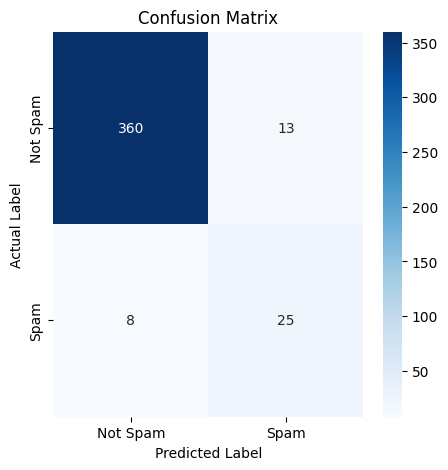

In [21]:
# Confusion Matrix & Evaluation Metrics
cm = confusion_matrix(true_labels_list, predictions_list)
print(f"Confusion Matrix:\n{cm}")

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Generate and print the classification report
classification_rep = classification_report(true_labels_list, predictions_list, target_names=['not spam', 'spam'])
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    not spam       0.98      0.97      0.97       373
        spam       0.66      0.76      0.70        33

    accuracy                           0.95       406
   macro avg       0.82      0.86      0.84       406
weighted avg       0.95      0.95      0.95       406



In [23]:
# Save model

model.save_pretrained("../models/v3-tuned")
tokenizer.save_pretrained("../models/v3-tuned")

('../models/v3-tuned/tokenizer_config.json',
 '../models/v3-tuned/special_tokens_map.json',
 '../models/v3-tuned/vocab.txt',
 '../models/v3-tuned/added_tokens.json',
 '../models/v3-tuned/tokenizer.json')

In [24]:
tokenizer = AutoTokenizer.from_pretrained("../models/v3-tuned")
model = AutoModelForSequenceClassification.from_pretrained("../models/v3-tuned")

In [34]:
# Define a function
def predict_spam(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = torch.argmax(probs, dim=1).item()
    label_map = {0: "HAM", 1: "SPAM"}
    confidence = probs[0][predicted_label].item()
    return label_map[predicted_label], confidence

In [26]:
# Teks input
input_text = "�� 🔥 PSN 100 Deal �� #EAFC26 #EAFC 100€ PSN für nur 80,64€ ��19,36€ geschenkt �� https://t.co/ilhqQHizDy* 🔑Code: FORAUM8JUL Besten Preis wählen und mit SEPA zahlen #deal_bot #Guthaben #Rabatt #PSN #FIFA"

# Tokenisasi
tokenized = tokenizer(
    input_text,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt",
)

# Cara 1: Lihat tokens (teks yang dipotong-potong)
print("=== TOKENS (Teks yang Dipotong) ===")
tokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"][0])
print("Tokens:", tokens[:20])  # Tampilkan 20 pertama

# Cara 2: Lihat teks lengkap yang sudah di-decode
print("\n=== TEKS LENGKAP ===")
decoded_text = tokenizer.decode(tokenized["input_ids"][0])
print("Decoded Text:", decoded_text)

# Cara 3: Prediksi dengan hasil yang mudah dibaca
print("\n=== PREDIKSI ===")
with torch.no_grad():
    outputs = model(**tokenized)
    probs = torch.softmax(outputs.logits, dim=1)
    predicted_label = torch.argmax(probs, dim=1).item()
    confidence = probs[0][predicted_label].item()

label_map = {0: "HAM", 1: "SPAM"}
print(f"Hasil: {label_map[predicted_label]}")
print(f"Kepercayaan: {confidence:.2%}")

=== TOKENS (Teks yang Dipotong) ===
Tokens: ['[CLS]', '[UNK]', 'ps', '##n', '100', 'deal', '#', 'ea', '##fc', '##26', '#', 'ea', '##fc', '[UNK]', 'ps', '##n', 'fur', 'nur', '80', ',']

=== TEKS LENGKAP ===
Decoded Text: [CLS] [UNK] psn 100 deal # eafc26 # eafc [UNK] psn fur nur 80, [UNK] 19, [UNK] geschenkt https : / / t. co / ilhqqhizdy * [UNK] : foraum8jul besten preis wahlen und mit sepa zahlen # deal _ bot # guthaben # rabatt # psn # fifa [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

=== PREDIKSI ===
Hasil: SPAM
Kepercayaan: 99.71%


In [35]:
# Percobaan prediksi apakah pesan adalah spam atau bukan
input_text = 'Senin, 21 Juli 2025, Samapta Polsek Ngaglik melaksanakan patroli stasioner balong jalan palagan donoharjo serta antisipasi gangguan Kamtibmas, Curat, Curas, Curan dan kejahatan jalanan di wilayah Ngaglik. https://t.co/TyIvxehCV9'
print(predict_spam(input_text, model, tokenizer))

('HAM', 0.9997528195381165)


In [36]:
input_text = 'lacak hp hilang by no hp / imei lacak penipu/scammer/tabrak lari/terror/revengeporn sadap / hack / pulihkan akun #zonauang #zonauang?'
print(predict_spam(input_text, model, tokenizer))

('SPAM', 0.9805166125297546)


In [ ]:
input_text = ''
print(predict_spam(input_text, model, tokenizer))

('SPAM', 0.6278573274612427)
